In [2]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm 
import time

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transformação para converter a imagem em tensor
transform = transforms.Compose([transforms.ToTensor()])

# Baixa e carrega o dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
batchsize = 16384
loaderTrain = DataLoader(train_data, shuffle=True, batch_size=batchsize, drop_last=True,num_workers=6, pin_memory=True)
loaderTest = DataLoader(test_data, batch_size=len(test_data),num_workers=6, pin_memory=True)

In [5]:
torch.argmax(train_data[1][0], axis=1)

tensor([[ 0,  0,  0,  0,  0,  0, 19, 19, 14, 12, 11, 10,  9,  9,  7,  6,  9,  4,
          5,  6,  9, 14, 14,  0,  0,  0,  0,  0]])

In [6]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
%whos

Variable      Type          Data/Info
-------------------------------------
DataLoader    type          <class 'torch.utils.data.dataloader.DataLoader'>
F             module        <module 'torch.nn.functio<...>/torch/nn/functional.py'>
batchsize     int           16384
datasets      module        <module 'torchvision.data<...>on/datasets/__init__.py'>
device        device        cuda
loaderTest    DataLoader    <torch.utils.data.dataloa<...>object at 0x73c94d078bb0>
loaderTrain   DataLoader    <torch.utils.data.dataloa<...>object at 0x73c94d07b190>
nn            module        <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np            module        <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt           module        <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
test_data     MNIST         Dataset MNIST\n    Number<...> ToTensor()\n           )
time          module        <module 'time' (built-in)>
torch         module        <module 'torch' from '/ho

In [8]:
def createMNISTNet(n_layers, n_units):
    class ann(nn.Module):
        def __init__(self):
            super().__init__()
            
            bnIn = nn.BatchNorm1d(784)
            input = nn.Linear(784, n_units)
            
            self.layers = nn.ModuleList()
            
            self.layers.append(bnIn)
            self.layers.append(input)
            self.layers.append(nn.ReLU())
            
            for i in range(n_layers):
                block= nn.Sequential(
                    nn.BatchNorm1d(n_units),
                    nn.Linear(n_units,n_units),
                    nn.ReLU()
                )
                self.layers.append(block)
                
            bnOut = nn.BatchNorm1d(n_units)
            output = nn.Linear(n_units,10)
            
            self.layers.append(bnOut)
            self.layers.append(output)
        
        def forward(self, x):
            x = x.view(-1,784)
            
            for layer in self.layers:
                x = layer(x)
            
            return torch.log_softmax(x, axis=1)
    
    net = ann()
    lossfun = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    
    return net, lossfun, optimizer

def trainModel(net, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    losses = []
    net.to(device)
    
    for epoch in tqdm(range(30), desc="Epoch", leave=False):
        batchAcc = []
        batchLoss = []
        net.train()
        
        for X,y in loaderTrain:
            X, y = X.to(device), y.to(device)
            
            y_pred = net(X)
            
            loss = lossfun(y_pred, y)
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = 100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item()
            batchAcc.append(acc)
    
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        net.eval()

        X, y = next(iter(loaderTest))
        X, y = X.to(device), y.to(device)
        y_pred = net(X)

        testAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
    return trainAcc, testAcc, losses
    
        
            

In [9]:
net, lossfun, optimizer = createMNISTNet(3,250)
X,y = next(iter(loaderTrain))

y_pred = net(X)

print(y_pred)
loss = lossfun(y_pred,y)
print("Loss", loss)

tensor([[-2.4520, -2.2972, -2.3703,  ..., -1.9030, -1.9621, -2.0449],
        [-1.9154, -2.6095, -2.3902,  ..., -2.5065, -2.7809, -2.3878],
        [-2.0933, -2.6180, -2.2333,  ..., -2.3092, -2.0762, -2.1992],
        ...,
        [-2.4313, -2.5888, -2.5414,  ..., -2.0879, -2.9141, -2.6635],
        [-1.9211, -2.9551, -1.9102,  ..., -2.3800, -2.5794, -2.4807],
        [-3.6221, -2.5437, -1.7671,  ..., -2.5299, -2.5546, -1.7853]],
       grad_fn=<LogSoftmaxBackward0>)
Loss tensor(2.4143, grad_fn=<NllLossBackward0>)


In [10]:
# train, test, loss = trainModel(net, lossfun, optimizer)

In [ ]:
AllTrain, AllTest, AllLosses = [], [], []
Units = [1,50,100,150,200,250]
layers = [1,2,3]
#train, test, loss = trainModel(net, lossfun, optimizer)
import itertools
configs = list(itertools.product(Units, layers))

print(f"Iniciando treinamento de {len(configs)} modelos...")

# MODIFICAÇÃO 2: Barra de progresso para os Modelos
for i, layer in tqdm(configs, desc="Modelos Totais"):
    
    # Opcional: print para saber exatamente onde está se der erro
    # tqdm.write usa o print de forma que não quebra a barra de progresso
    tqdm.write(f"Treinando: Units={i}, Layers={layer}") 
    
    net, lossfun, optimizer = createMNISTNet(n_units=i, n_layers=layer)
    # createMNISTNet não joga para GPU automaticamente, então:
    # net.to(device) 
    
    train, test, loss = trainModel(net, lossfun, optimizer)
    
    AllTrain.append(train)
    AllTest.append(test)
    AllLosses.append(loss)

Iniciando treinamento de 18 modelos...


Modelos Totais:   0%|          | 0/18 [00:00<?, ?it/s]

Treinando: Units=1, Layers=1


Modelos Totais:   6%|▌         | 1/18 [01:46<30:01, 106.00s/it]

Treinando: Units=1, Layers=2


Modelos Totais:  11%|█         | 2/18 [03:32<28:22, 106.42s/it]

Treinando: Units=1, Layers=3


Modelos Totais:  17%|█▋        | 3/18 [05:17<26:25, 105.67s/it]

Treinando: Units=50, Layers=1


Modelos Totais:  22%|██▏       | 4/18 [06:57<24:05, 103.26s/it]

Treinando: Units=50, Layers=2


Modelos Totais:  28%|██▊       | 5/18 [08:34<21:55, 101.19s/it]

Treinando: Units=50, Layers=3


Modelos Totais:  33%|███▎      | 6/18 [10:11<19:58, 99.85s/it] 

Treinando: Units=100, Layers=1


In [ ]:
train = np.array(AllTrain)
test = np.array(AllTest)
loss = np.array(AllLosses)

NameError: name 'np' is not defined

In [ ]:
train = train.reshape(3,len(Units), -1)

In [ ]:
train.shape

(3, 6, 30)

ValueError: x and y can be no greater than 2D, but have shapes (3,) and (3, 6, 30)

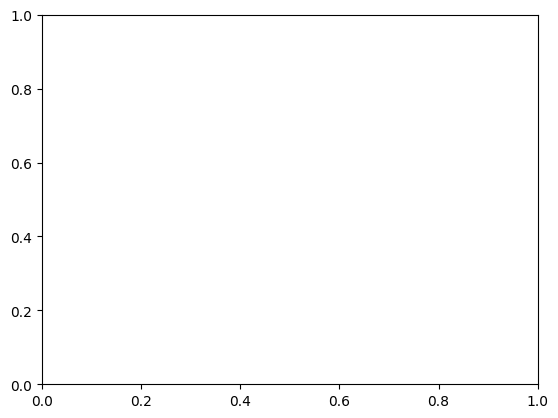

In [ ]:
plt.plot(train)
plt.legend("Train Test".split())


Traceback (most recent call last):
  File "/home/naia/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/naia/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/naia/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/naia/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/naia/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/naia/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/naia/miniconda3/envs/pytorch/li

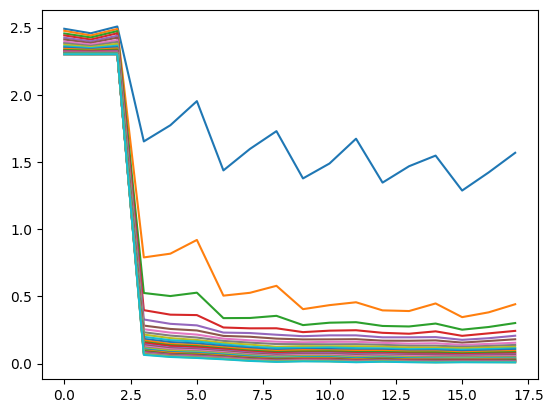

In [ ]:
plt.plot(AllLosses)